# Install neccessary libraries

In [1]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.4 MB/s eta 0:00:00


# Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as keras_utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorboard import program
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from prettytable import PrettyTable
import numpy as np
from tensorflow.keras import backend as K
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from tabulate import tabulate
import seaborn as sns
# import viznet
import graphviz
# from ann_visualizer.visualize import ann_viz
from tensorflow import keras

<ipython-input-2-991cd7984e63>:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Dataset

In [3]:
# Load the dataset
digits = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = digits.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Count the occurrences of each digit in the training set
train_digit_counts = np.bincount(y_train)

# Count the occurrences of each digit in the testing set
test_digit_counts = np.bincount(y_test)

# Calculate the subtotal by adding the counts from the training and testing sets
subtotal_digit_counts = train_digit_counts + test_digit_counts

# Calculate the total counts by summing the subtotal counts
total_digit_counts = np.sum(subtotal_digit_counts)

# Generate x-axis labels for each digit
digits = np.arange(10)

# Create a table
table = []
for digit, train_count, test_count, subtotal_count in zip(
    digits, train_digit_counts, test_digit_counts, subtotal_digit_counts
):
    table.append([digit, train_count, test_count, subtotal_count])

# Append a row for the subtotal
table.append(["Subtotal", np.sum(train_digit_counts), np.sum(test_digit_counts), np.sum(subtotal_digit_counts)])

# Append a row for the total
table.append(["Total", "", "", total_digit_counts])

# Define the table headers
headers = ["Digit", "Training Set", "Testing Set", "Subtotal"]

# Print the table
print(tabulate(table, headers, tablefmt="fancy_grid"))

╒══════════╤════════════════╤═══════════════╤════════════╕
│ Digit    │ Training Set   │ Testing Set   │   Subtotal │
╞══════════╪════════════════╪═══════════════╪════════════╡
│ 0        │ 5923           │ 980           │       6903 │
├──────────┼────────────────┼───────────────┼────────────┤
│ 1        │ 6742           │ 1135          │       7877 │
├──────────┼────────────────┼───────────────┼────────────┤
│ 2        │ 5958           │ 1032          │       6990 │
├──────────┼────────────────┼───────────────┼────────────┤
│ 3        │ 6131           │ 1010          │       7141 │
├──────────┼────────────────┼───────────────┼────────────┤
│ 4        │ 5842           │ 982           │       6824 │
├──────────┼────────────────┼───────────────┼────────────┤
│ 5        │ 5421           │ 892           │       6313 │
├──────────┼────────────────┼───────────────┼────────────┤
│ 6        │ 5918           │ 958           │       6876 │
├──────────┼────────────────┼───────────────┼───────────

# Pre-processing

In [5]:
# Reshape and normalise the data
X_train = X_train / 255.0
X_test = X_test / 255.0


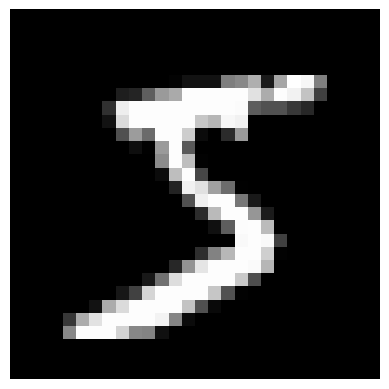

In [6]:
# Display the reshaped and normalised image
image = X_train[0].reshape(28, 28)  # Assuming the first image is displayed
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
# Split the data into training, validation, and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

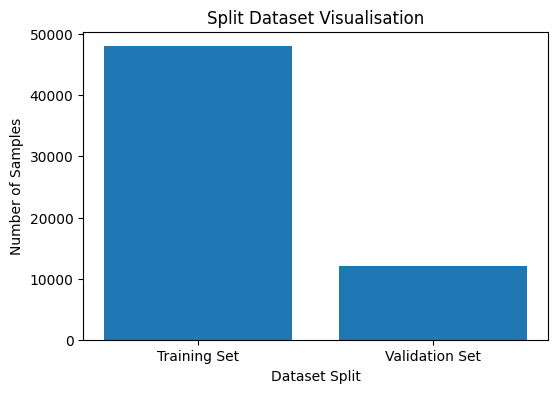

In [8]:
# Calculate the sizes of each split
train_size = len(X_train)
val_size = len(X_val)

#Display the training and Validation Set graph
# Plot the split dataset
plt.figure(figsize=(6, 4))
plt.bar(['Training Set', 'Validation Set'], [train_size, val_size])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.title('Split Dataset Visualisation')
plt.show()

# Deep Neural Network

In [9]:
# Define the model-building function
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Tune the number of units in the dense layer
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_initializer='random_normal'))

    model.add(tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='random_normal'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [10]:
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='mnist_tuning'
)

In [24]:
# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

In [12]:
# Get the best trials
trials = tuner.oracle.get_best_trials(num_trials=5)

In [13]:
# Create a fancy table
table = PrettyTable()
table.field_names = ["Trial", "Learning Rate", "Units", "Accuracy", "Validation Accuracy"]

# Add trial details to the table
for i, trial in enumerate(trials):
    learning_rate = trial.hyperparameters.get('learning_rate')
    units = trial.hyperparameters.get('units')
    accuracy = trial.metrics.get_last_value('accuracy')
    val_accuracy = trial.metrics.get_last_value('val_accuracy')
    table.add_row([i+1, learning_rate, units, accuracy, val_accuracy])

# Print the fancy table
print(table)

+-------+---------------+-------+--------------------+---------------------+
| Trial | Learning Rate | Units |      Accuracy      | Validation Accuracy |
+-------+---------------+-------+--------------------+---------------------+
|   1   |     0.001     |  160  | 0.9945000012715658 |  0.9785277843475342 |
|   2   |      0.01     |  192  | 0.968583325544993  |  0.9641388853391012 |
|   3   |     0.001     |   32  | 0.974055548508962  |  0.9635555545488993 |
|   4   |      0.01     |  224  | 0.973069449265798  |  0.9626111189524332 |
|   5   |      0.01     |  128  | 0.9750347137451172 |  0.9616666833559672 |
+-------+---------------+-------+--------------------+---------------------+


In [14]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [15]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 160)               125600    
                                                                 
 dense_1 (Dense)             (None, 10)                1610      
                                                                 
Total params: 127,210
Trainable params: 127,210
Non-trainable params: 0
_________________________________________________________________


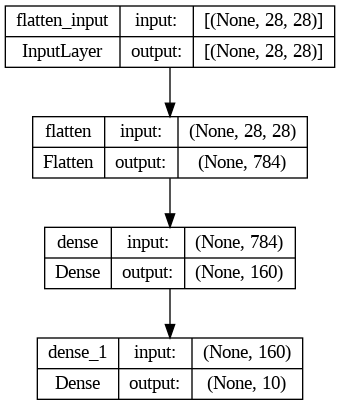

In [22]:
# Visualize the model architecture
plot_model(best_model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [17]:
# Train the best model with the optimal hyperparameters
best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
1500/1500 [==============================] - 9s 5ms/step - loss: 0.0147 - accuracy: 0.9959 - val_loss: 0.0849 - val_accuracy: 0.9791
Epoch 2/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0139 - accuracy: 0.9959 - val_loss: 0.0878 - val_accuracy: 0.9787
Epoch 3/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0098 - accuracy: 0.9971 - val_loss: 0.0867 - val_accuracy: 0.9787
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0103 - accuracy: 0.9970 - val_loss: 0.0988 - val_accuracy: 0.9787
Epoch 5/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0978 - val_accuracy: 0.9801
Epoch 6/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.1049 - val_accuracy: 0.9779
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.1147 - val_accuracy

In [18]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate precision, recall, and F1 score
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Display
print("Loss", test_loss)
print("Accurancy", test_accuracy)
print()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

313/313 [==============================] - 1s 2ms/step
Loss 0.11111302673816681
Accurancy 0.977400004863739

Accuracy: 0.9774
Precision: 0.9771713583868351
Recall: 0.9774643025308268
F1 Score: 0.9772585890963995


# Results

In [19]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_rows = [[label] + list(values.values()) for label, values in report.items() if label.isdigit()]
headers = ['Digits', 'Precision', 'Recall', 'F1-Score']

# Print the results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("")

print("Deep Neuron Network Report:")
print(tabulate(report_rows, headers=headers, tablefmt='orgtbl'))

Test Loss: 0.11111302673816681
Test Accuracy: 0.977400004863739

Deep Neuron Network Report:
|    |   Digits |   Precision |   Recall |   F1-Score |
|----+----------+-------------+----------+------------|
|  0 | 0.98073  |    0.986735 | 0.983723 |        980 |
|  1 | 0.987709 |    0.991189 | 0.989446 |       1135 |
|  2 | 0.985075 |    0.959302 | 0.972018 |       1032 |
|  3 | 0.978218 |    0.978218 | 0.978218 |       1010 |
|  4 | 0.976602 |    0.977597 | 0.977099 |        982 |
|  5 | 0.962882 |    0.988789 | 0.975664 |        892 |
|  6 | 0.982199 |    0.979123 | 0.980659 |        958 |
|  7 | 0.987013 |    0.961089 | 0.973879 |       1028 |
|  8 | 0.968432 |    0.976386 | 0.972393 |        974 |
|  9 | 0.962854 |    0.976214 | 0.969488 |       1009 |


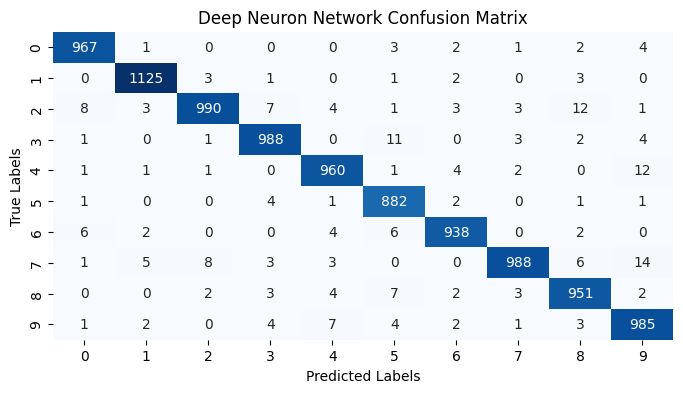

In [20]:
# Calculate confusion matrix
dnn_cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(dnn_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Deep Neuron Network Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

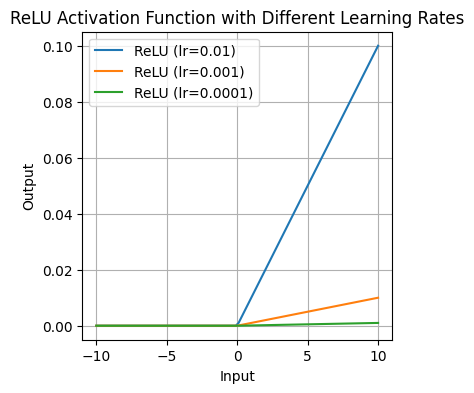

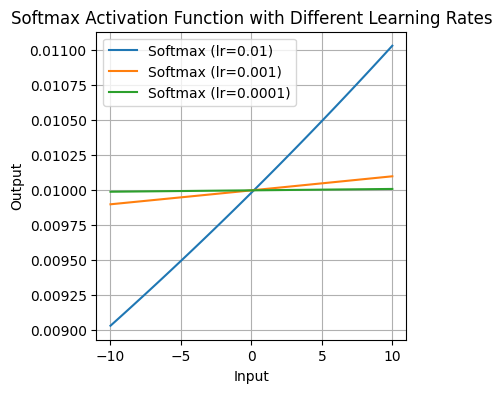

In [30]:
# Define the ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Define the Softmax activation function
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

# Generate input values
x = np.linspace(-10, 10, 100)

# Set the learning rate values
learning_rates = [1e-2, 1e-3, 1e-4]

# Plot ReLU for each learning rate
plt.figure(figsize=(4, 4))
for lr in learning_rates:
    relu_output = relu(lr * x)
    plt.plot(x, relu_output, label=f'ReLU (lr={lr})')

plt.title('ReLU Activation Function with Different Learning Rates')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot Softmax for each learning rate
plt.figure(figsize=(4, 4))
for lr in learning_rates:
    softmax_output = softmax(lr * x)
    plt.plot(x, softmax_output, label=f'Softmax (lr={lr})')

plt.title('Softmax Activation Function with Different Learning Rates')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()